#Neural Networks with Pytorch
The primary objective in this notebook is to train a simple fully connected, feedforward neural network to classify Synthetic Aperture Radar (SAR) images of military vehicles. Hopefully this is an interesting departure from the usual MNIST/CIFAR datasets that you will likely come across in other tutorials.

In this case there are certainly better architectures to use, but we are not too concerned with achieving optimal results for this assignment.

In [ ]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import SubsetRandomSampler
from PIL import Image
import random

For this assigment we will be using a dataset consisting of Synthetic Aperture Radar (SAR) images taken of various targets. The targets are military vehicles such as tanks, patrol vehicles etc. We will consider 8 different targets as shown by their "natural" images below.
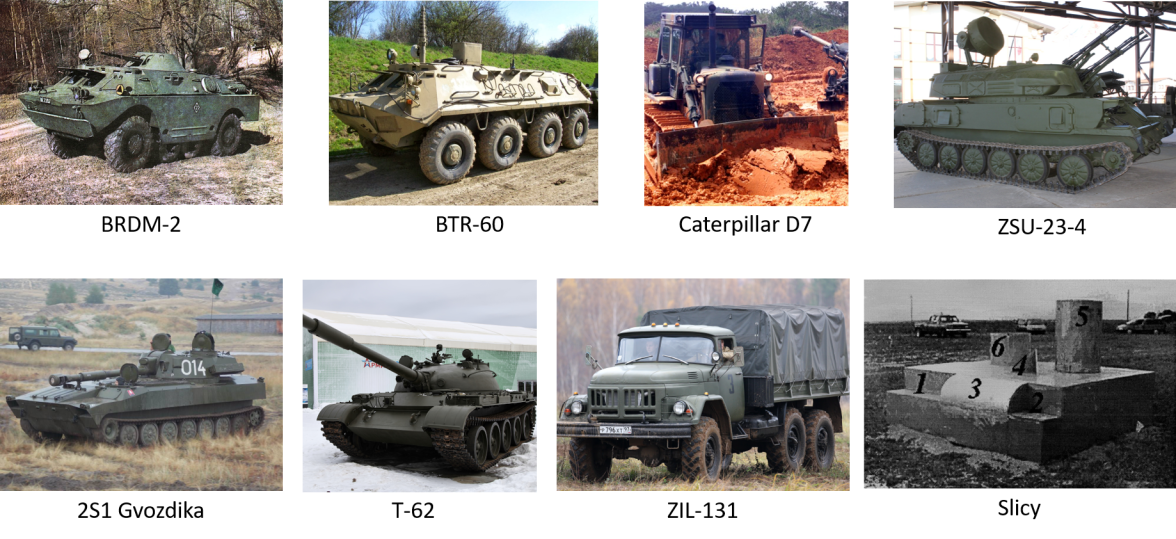

The "Slicy" target is essentially acting as a baseline target which has been designed with standard radar reflector shapes.

## Loading the data
I have provided the data as `.npy` files. The input data provided consists of two sets of SAR images. Each set is taken from a different azimuth ($15^{\circ}$ and $17^{\circ}$).

The code below assumes you have saved the dataset in a Google drive folder mounted in Colab.

You can change this to suit your requirements.

I have an independant test set that will be used to test your trained networks.

In [ ]:
x_15 = np.load(Path.cwd() / "drive" / "MyDrive" / "CPD"/ "input_15.npy")
y_15 = np.load(Path.cwd()  / "drive" / "MyDrive" / "CPD"/ "label_15.npy")
x_17 = np.load(Path.cwd()  / "drive" / "MyDrive" / "CPD"/ "input_17.npy")
y_17 = np.load(Path.cwd()  / "drive" / "MyDrive" / "CPD"/ "label_17.npy")

# Combine 15 degree and 17 degree datasets
x = np.concatenate((x_15, x_17))
y = np.concatenate((y_15, y_17))

In [ ]:
x_15 = np.load("/content/drive/MyDrive/CPD/input_15.npy") # or copy path directly from the file browser

In [ ]:
print("The total x shape: {}\n".format(x.shape))
print("Example of a training input\n{}\n".format(x[0]))
print("The total y shape: {}\n".format(y.shape))
print("List of all possible labels\n{}\n".format(np.unique(y)))

The total x shape: (4459, 54, 54)

Example of a training input
[[1.05225842 1.03215903 1.01849144 ... 1.07878961 1.05547432 1.01607951]
 [1.01688349 1.01527554 1.00964771 ... 1.07798564 1.05788625 1.04180674]
 [1.01768746 1.02492324 1.03215903 ... 1.02411927 1.04904252 1.0627101 ]
 ...
 [1.04663059 1.05065047 1.01929541 ... 1.06833793 1.03376698 1.02170734]
 [1.04743456 1.04663059 1.02572722 ... 1.06190613 1.01929541 1.04019878]
 [1.03135505 1.02251132 1.01768746 ... 1.0627101  1.02170734 1.04180674]]

The total y shape: (4459,)

List of all possible labels
[b'brdm2' b'btr60' b'd7' b'slicy' b't2s1' b't62' b'zil131' b'zsu23_4']



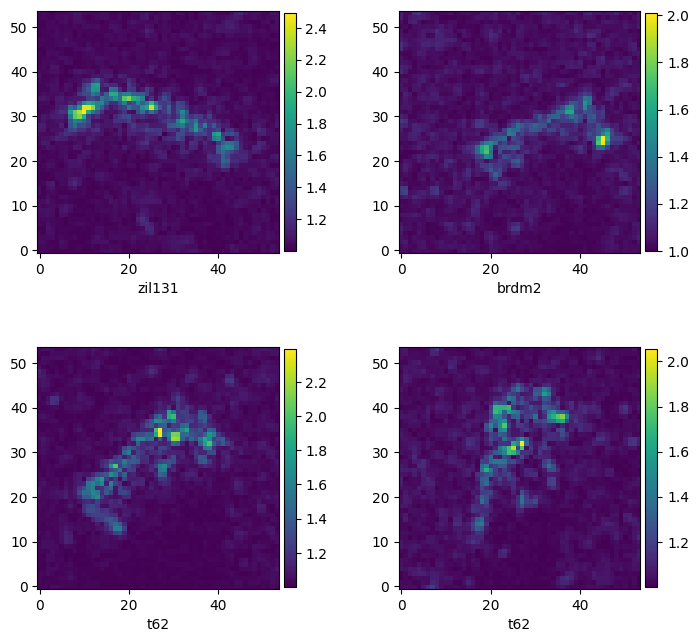

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))
fig.subplots_adjust(wspace=0.4)
axes = axes.ravel()

for i, example in enumerate(random.sample(range(0, x.shape[0]), 4)):
    img = axes[i].imshow(x[example], origin='lower') #or cmap='gray' for grayscale to not get confused with a 3 channel (rgb) image
    axes[i].set_xlabel(y[example].decode("utf-8"))
    fig.colorbar(img, ax=axes[i], fraction=0.046, pad=0.02)

plt.show()

From these SAR images you might appreciate the interesting aspects of this problem. It might be fairly easy for a human to classify the natural images, but here we have something which we might not have an immediate intuition for. Hopefully we can build classifiers that can do this for us!

Before we move on there is some additional data preprocessing that needs to be done.

# Custom Dataset
Libraries such as Pytorch offer mechanisms for efficiently loading data during training and evaluation. Here is a custom dataloader for the radar dataset.

We could use these datasets and dataloaders to perform transformations on the data on-the-fly rather than making the modifications on the entire dataset beforehand.

The loss function we will use in Pytorch assumes that each class is represented by an interger value, and will do any other transformations internally. Sometimes you will come across examples where the outputs are one-hot encoded e.g. $[0\ 0\ 0\ 1\ 0]$ where the value at a particular index has a value of 1 for the class corresponding to the input and 0 for every other index.

The code below is used to create easier to use datasets. No need to worry about how it works, just that it will help make loading data much easier later.

In [ ]:
class MSTAR(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.transform = transform
        self.enc = LabelEncoder()
        targets = self.enc.fit_transform(targets.reshape(-1,))
        self.targets = torch.LongTensor(targets)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = int(index.item())

        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = Image.fromarray(self.data[index])
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

## Normalizing, scaling, standardizing inputs
The numerical values of the inputs is important, as they can impact how the optimizer traverses the loss function.
For an easy to digest explanation see [About Feature Scaling and Normalization](https://sebastianraschka.com/Articles/2014_about_feature_scaling.html).

Before scaling it is important to make sure that the parameters used to scale/normalize/standardize (e.g. mean, standard deviation, min, max etc.) are calculated using the data for training (updating parameters) and not the data held out of validation/testing. Otherwise you would be getting your statistics from supposedly "unseen" data which leads to information leak.

Below I have done a threeway holdout split, but you can change these splits if you wish.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4)

I have used the MinMaxScaler() to scale the inputs between 0 and 1, as required by Pytorch if you want to use their built-in transforms for images. You can edit the cell below if you wish. Just note that this will be the data used throughout the notebook.


In [ ]:
scaler = MinMaxScaler() #or StandardScaler() if you want 0 mean and a std. dev of 1
x_train_shape = x_train.shape
x_val_shape = x_val.shape
x_test_shape = x_test.shape

# fit scaler on training data, and transform it as well
x_train = scaler.fit_transform(x_train.reshape(-1, 1))
x_train = x_train.reshape(x_train_shape)

# only transform sets used for evaluation
x_val = scaler.transform(x_val.reshape(-1, 1))
x_val = x_val.reshape(x_val_shape)

x_test = scaler.transform(x_test.reshape(-1, 1))
x_test = x_test.reshape(x_test_shape)

In [ ]:
# Some hyperparameters
BATCH_SIZE = 64 #mini_batches

# Pytorch lets you define sets of transformations to apply on the data as it is
transform = transforms.Compose(
    [
     transforms.ToTensor()
    ])

# define datasets. One for each of the splits.
train_dataset = MSTAR(x_train, y_train, transform=transform)
val_dataset = MSTAR(x_val, y_val, transform=transform)
test_dataset = MSTAR(x_test, y_test, transform=transform)

# define dataloaders, again, one for each dataset that was created
# (make sure the dataset argument to DataLoader() is using the correct dataset
# e.g. train_dataset for the training set dataloader. Again they might have used
# different naming conventions so just check what's going where)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True)

# The amount of evaluation data could be loaded in all at once.
# You could also provided batches if these sets were very large
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

In [ ]:
# Many deep learning libraries offer easy support for hardware acceleration
# Colab offers GPU resources for free, but the amount of resources you recieve can vary with the free tier.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [ ]:
class Net(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(Net, self).__init__()
            self.flatten = torch.nn.Flatten() # needed to change the 2D images to 1D
            self.input_size = input_size
            self.hidden_size  = hidden_size

            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            self.fc2 = torch.nn.Linear(self.hidden_size, 8)
            self.sigmoid = torch.nn.Sigmoid()

        def forward(self, x):
            x = self.flatten(x)
            x = self.fc1(x)
            x = self.relu(x)
            x = self.fc2(x)
            output = self.sigmoid(x)
            return output

In [ ]:
model = Net(54*54, 128).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01) #SGD lr=0.1, momentum=0.9
print(model)

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2916, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=8, bias=True)
  (sigmoid): Sigmoid()
)


In [ ]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0 #only really necessary if loading minibatches for evaluation - often if there is too much data to load at once.
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            running_loss += loss.item()

    # Return mean loss, accuracy
    return running_loss / len(loader), correct / total

In [ ]:
history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
}

running_loss = 0.0
total = 0.0
MAX_EPOCHS = 50
for epoch in range(MAX_EPOCHS):  # loop over the dataset multiple times
    print("Starting Epoch: {}".format(epoch+1))
    for i, data in enumerate(train_loader, 0):
        model.train()

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # # keep record of loss across mini-batches until logged
        # running_loss += loss.item()

        # log results
        if i % 10 == 9:    # log every 10 mini-batches
            # mean_loss = running_loss / 10

            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == labels).sum().item()
            train_acc = correct / labels.size(0)

            history['train_loss'].append(loss.item())
            history['train_acc'].append(train_acc)

            print('# mini-batch {}\ntrain loss: {} train accuracy: {}'.format(
                  i + 1, loss.item(), train_acc))
            # running_loss = 0.0

            # evaluate on validation dataset
            mean_val_loss, val_acc = evaluate(model, val_loader)
            history['val_loss'].append(mean_val_loss)
            history['val_acc'].append(val_acc)

            print("validation loss: {} validation accuracy: {}\n".format(mean_val_loss, val_acc))

print('Finished Training')

Starting Epoch: 1
# mini-batch 10
train loss: 2.0786831378936768 train accuracy: 0.09375
validation loss: 2.0792036056518555 validation accuracy: 0.12577833125778332

# mini-batch 20
train loss: 2.080294132232666 train accuracy: 0.171875
validation loss: 2.078775644302368 validation accuracy: 0.12577833125778332

# mini-batch 30
train loss: 2.077847957611084 train accuracy: 0.109375
validation loss: 2.0785694122314453 validation accuracy: 0.12640099626400997

Starting Epoch: 2
# mini-batch 10
train loss: 2.078176975250244 train accuracy: 0.09375
validation loss: 2.0789356231689453 validation accuracy: 0.12577833125778332

# mini-batch 20
train loss: 2.0800845623016357 train accuracy: 0.171875
validation loss: 2.0790727138519287 validation accuracy: 0.12577833125778332

# mini-batch 30
train loss: 2.0783350467681885 train accuracy: 0.109375
validation loss: 2.0790748596191406 validation accuracy: 0.12577833125778332

Starting Epoch: 3
# mini-batch 10
train loss: 2.0783116817474365 train

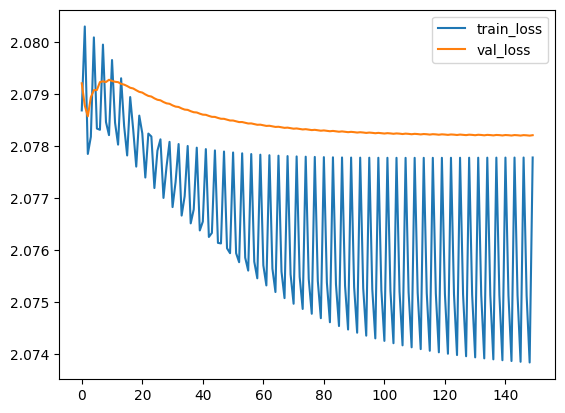

In [ ]:
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.legend()
plt.show()

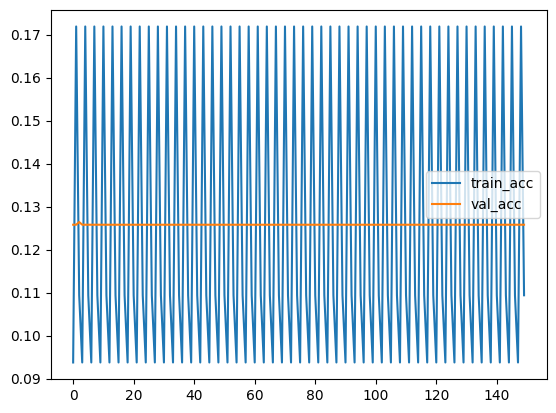

In [ ]:
plt.plot(history['train_acc'], label='train_acc')
plt.plot(history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [ ]:
for data in train_loader:
  print(data[1])
  print(train_dataset.enc.inverse_transform(data[1]))
  break

tensor([0, 5, 6, 5, 7, 5, 3, 5, 7, 5, 3, 0, 6, 2, 0, 4, 2, 1, 4, 4, 7, 1, 0, 4,
        6, 0, 7, 0, 5, 5, 4, 5, 1, 7, 0, 7, 3, 5, 0, 4, 2, 2, 2, 7, 1, 1, 2, 2,
        2, 5, 3, 7, 2, 6, 2, 2, 0, 2, 5, 5, 7, 5, 1, 7])
[b'brdm2' b't62' b'zil131' b't62' b'zsu23_4' b't62' b'slicy' b't62'
 b'zsu23_4' b't62' b'slicy' b'brdm2' b'zil131' b'd7' b'brdm2' b't2s1'
 b'd7' b'btr60' b't2s1' b't2s1' b'zsu23_4' b'btr60' b'brdm2' b't2s1'
 b'zil131' b'brdm2' b'zsu23_4' b'brdm2' b't62' b't62' b't2s1' b't62'
 b'btr60' b'zsu23_4' b'brdm2' b'zsu23_4' b'slicy' b't62' b'brdm2' b't2s1'
 b'd7' b'd7' b'd7' b'zsu23_4' b'btr60' b'btr60' b'd7' b'd7' b'd7' b't62'
 b'slicy' b'zsu23_4' b'd7' b'zil131' b'd7' b'd7' b'brdm2' b'd7' b't62'
 b't62' b'zsu23_4' b't62' b'btr60' b'zsu23_4']
